In [1]:
cd("$(homedir())/Documents/Repos/enso_project.jl")
using Pkg
Pkg.activate(".")

  Activating project at `C:\Users\lisah\Documents\Repos\enso_project.jl`


In [2]:
using ReservoirComputing, CSV, DataFrames, DynamicalSystems, Plots, enso_project, Statistics, JLD2, DelayEmbeddings

┌ Warning: Package cuDNN not found in current path.
│ - Run `import Pkg; Pkg.add("cuDNN")` to install the cuDNN package, then restart julia.
│ - If cuDNN is not installed, some Flux functionalities will not be available when running on the GPU.
└ @ FluxCUDAExt C:\Users\lisah\.julia\packages\Flux\9PibT\ext\FluxCUDAExt\FluxCUDAExt.jl:10


## Perform error analysis on MJO predictions

### prepare data

In [3]:
# load data
header = ["year", "month", "day", "hour", "PC1 coeff", "PC2 coeff", "PC1+PC2 amplitude"]
data = CSV.read("data/mjo_data/mjo_romi.txt", DataFrame; delim=" ", ignorerepeated=true, header=header)
pc1 = data[!,"PC1 coeff"]
pc2 = data[!,"PC2 coeff"];

# perform TDE with negative shift
#D1, τ1 = enso_project.tde_with_negative_shift(pc1)
#D2, τ2 = enso_project.tde_with_negative_shift(pc2)
#D1, D2 = D1', D2';

# perform standard implemented TDE with positive shift
D1, τ1, E1 = optimal_separated_de(pc1)
D2, τ2, E2 = optimal_separated_de(pc2)
D1, D2 = Matrix(D1)', Matrix(D2)'

Algorithm stopped due to convergence of E₁-statistic. Valid embedding achieved ✓.
Algorithm stopped due to convergence of E₁-statistic. Valid embedding achieved ✓.


([0.12526 0.18542 … -0.61861 -0.67318; 0.36751 0.41747 … -0.75858 -0.72177; … ; 0.64762 0.81565 … 0.0574 -0.11773; 1.36361 1.26646 … -0.33531 -0.37026], [-0.06945 -0.04887 … -0.18231 -0.21513; 0.39319 0.31856 … 0.18309 0.1745; … ; -0.76322 -0.56306 … 0.02261 0.06082; -0.65529 -0.54175 … -0.38871 -0.34477])

In [4]:
# train, test, val splits
train_size = 10000
val_size = 2000
test_size = size(D1,2) - train_size - val_size
#test_size = size(pc1',2) - train_size - val_size

519

### gather prediction samples

In [5]:
# sample size N # TODO: adjust sample size
N = 200

# lead time L
L = 60

# check whether test set is large enough
test_size > N+L

true

### training

In [6]:
pos_shift_tde = true;

In [24]:
# for no TDE case
#D1 = pc1'
#D2 = pc2'

In [7]:
spectral_radii = [0.8,0.9,1.0]
sparsities = [0.14,0.1,0.5]
input_scales = [0.1,1.0]
ridge_values = [0.0,1e-5, 1e-6]
reservoir_sizes = [500,700,1000]

param_grid = enso_project.create_param_grid(reservoir_sizes, spectral_radii, sparsities, input_scales, ridge_values);

In [8]:
# pc1
predictions_pc1, datasets_test_pc1 = enso_project.sample_lead_times(L,N,D1, train_size, val_size,param_grid; pos_shift_tde=pos_shift_tde)

enso_project.ESNHyperparams(500, 0.8, 0.14, 0.1, 0.0)
Validation loss = 2146.327039527437
enso_project.ESNHyperparams(500, 0.8, 0.5, 0.1, 0.0)
Validation loss = 1836.2846995361306
Finished sample 1
enso_project.ESNHyperparams(500, 0.8, 0.14, 0.1, 0.0)
Validation loss = 2146.7807274279357
enso_project.ESNHyperparams(500, 0.8, 0.5, 0.1, 0.0)
Validation loss = 1836.3116638659153
Finished sample 2
enso_project.ESNHyperparams(500, 0.8, 0.14, 0.1, 0.0)
Validation loss = 2147.0815508061073
enso_project.ESNHyperparams(500, 0.8, 0.5, 0.1, 0.0)
Validation loss = 1836.3117190692938
Finished sample 3
enso_project.ESNHyperparams(500, 0.8, 0.14, 0.1, 0.0)
Validation loss = 2147.1726741957173
enso_project.ESNHyperparams(500, 0.8, 0.5, 0.1, 0.0)
Validation loss = 1836.410118456704
Finished sample 4
enso_project.ESNHyperparams(500, 0.8, 0.14, 0.1, 0.0)
Validation loss = 2147.1731159334417
enso_project.ESNHyperparams(500, 0.8, 0.5, 0.1, 0.0)
Validation loss = 1836.7981570907532
Finished sample 5
enso_pr

([-0.9653691545091888 -0.8179917125331438 … 0.28348822080357894 0.3088959647260517; -0.8899745794387999 -0.7368640404178619 … 0.3618171052217009 0.39271470055066887; … ; 0.9755647342123807 0.8109334977588775 … 0.41199163600464034 0.3738462427708269; 0.9436450181678875 0.8364075683841774 … 0.35034579211112055 0.2767887862361341], [-1.00198 -0.99269 … -0.33316 -0.295; -0.99269 -0.9764 … -0.295 -0.23475; … ; 1.04004 0.88814 … 0.69629 0.24112; 0.88814 0.76656 … 0.24112 -0.27262])

In [9]:
CSV.write("C:/Users/lisah/Documents/Repos/enso_project.jl/temp_saves/error_saves/mjo_pos_shift_tde_L$(L)_N$(N)_predictions_pc1.csv", DataFrame(predictions_pc1, :auto))
CSV.write("C:/Users/lisah/Documents/Repos/enso_project.jl/temp_saves/error_saves/mjo_pos_shift_tde_L$(L)_N$(N)_testsets_pc1.csv", DataFrame(datasets_test_pc1, :auto))

"C:/Users/lisah/Documents/Repos/enso_project.jl/temp_saves/error_saves/mjo_pos_shift_tde_L60_N200_testsets_pc1.csv"

In [10]:
# pc2
predictions_pc2, datasets_test_pc2 = enso_project.sample_lead_times(L,N,D2, train_size, val_size, param_grid; pos_shift_tde=pos_shift_tde)

enso_project.ESNHyperparams(500, 0.8, 0.14, 0.1, 0.0)
Validation loss = 1504.0411565991556
enso_project.ESNHyperparams(1000, 0.8, 0.14, 0.1, 0.0)
Validation loss = 1369.1422972728665
enso_project.ESNHyperparams(500, 0.8, 0.1, 0.1, 0.0)
Validation loss = 1232.009525609345
enso_project.ESNHyperparams(500, 0.8, 0.1, 0.1, 1.0e-5)
Validation loss = 1231.7806707544094
Finished sample 1
enso_project.ESNHyperparams(500, 0.8, 0.14, 0.1, 0.0)
Validation loss = 1504.0520166749277
enso_project.ESNHyperparams(1000, 0.8, 0.14, 0.1, 0.0)
Validation loss = 1369.6359652333122
enso_project.ESNHyperparams(500, 0.8, 0.1, 0.1, 0.0)
Validation loss = 1232.0278318212731
enso_project.ESNHyperparams(500, 0.8, 0.1, 0.1, 1.0e-5)
Validation loss = 1231.7993013726955
Finished sample 2
enso_project.ESNHyperparams(500, 0.8, 0.14, 0.1, 0.0)
Validation loss = 1504.2049746546472
enso_project.ESNHyperparams(1000, 0.8, 0.14, 0.1, 0.0)
Validation loss = 1370.4825094005569
enso_project.ESNHyperparams(500, 0.8, 0.1, 0.1, 0.

([-1.1444688945530443 -1.3463218423202268 … 0.4252701854779706 0.38793656029466594; -1.2196846781050092 -1.3226246004147186 … 0.3885588732873588 0.3601017245609957; … ; -0.5831735560675101 -0.3516314606543683 … 0.42706274796818616 0.4989985500134113; -0.3545400029026609 -0.09784276613915303 … 0.5193229248274187 0.5703967775305793], [-1.0902 -1.10705 … -0.70967 -0.54446; -1.10705 -1.06785 … -0.54446 -0.55808; … ; -0.58507 -0.32449 … 0.59632 0.42182; -0.32449 -0.01559 … 0.42182 0.22535])

In [11]:
CSV.write("C:/Users/lisah/Documents/Repos/enso_project.jl/temp_saves/error_saves/mjo_pos_shift_tde_L$(L)_N$(N)_predictions_pc2.csv", DataFrame(predictions_pc2, :auto))
CSV.write("C:/Users/lisah/Documents/Repos/enso_project.jl/temp_saves/error_saves/mjo_pos_shift_tde_L$(L)_N$(N)_testsets_pc2.csv", DataFrame(datasets_test_pc2, :auto))

"C:/Users/lisah/Documents/Repos/enso_project.jl/temp_saves/error_saves/mjo_pos_shift_tde_L60_N200_testsets_pc2.csv"

### error analysis with neg. shift TDE

In [74]:
predictions_pc1 = Matrix(CSV.read("C:/Users/lisah/Documents/Repos/enso_project.jl/temp_saves/error_saves/mjo_tde_L$(L)_N$(N)_predictions_pc1.csv", DataFrame))
datasets_test_pc1 = Matrix(CSV.read("C:/Users/lisah/Documents/Repos/enso_project.jl/temp_saves/error_saves/mjo_tde_L$(L)_N$(N)_testsets_pc1.csv", DataFrame));

predictions_pc2 = Matrix(CSV.read("C:/Users/lisah/Documents/Repos/enso_project.jl/temp_saves/error_saves/mjo_tde_L$(L)_N$(N)_predictions_pc2.csv", DataFrame))
datasets_test_pc2 = Matrix(CSV.read("C:/Users/lisah/Documents/Repos/enso_project.jl/temp_saves/error_saves/mjo_tde_L$(L)_N$(N)_testsets_pc2.csv", DataFrame));

In [75]:
rmse_vals = enso_project.rmse(predictions_pc1, datasets_test_pc1, predictions_pc2, datasets_test_pc2)
corr_vals = enso_project.bivariate_corr(predictions_pc1, datasets_test_pc1, predictions_pc2, datasets_test_pc2)
error_tde = plot(rmse_vals, label="RMSE", xlabel="Lead Times (days)", ylabel="Error Index", ylim=(-0.3,2.3), title="MJO Prediction neg. TDE", color=:blue)
plot!(corr_vals,label="CORR",color=:orange)
hline!([1.4], color=:blue, linestyle=:dash, label="")
hline!([0.5], color=:orange, linestyle=:dash, label="");
#savefig("C:/Users/lisah/Documents/Repos/enso_project.jl/temp_saves/fig_saves/mjo_error.png")

In [76]:
phase_error = enso_project.phase_error(predictions_pc1, datasets_test_pc1, predictions_pc2, datasets_test_pc2)
phase_error_tde = plot(phase_error, ylim=(-0.3,0.3), label="phase error", xlabel="Lead Time (days)", ylabel="", title="MJO Prediction neg. TDE", color=:blue);

In [77]:
hss_vals = enso_project.hss(predictions_pc1,predictions_pc2,datasets_test_pc1, datasets_test_pc2)

hss_tde = heatmap(hss_vals,
    #color=:viridis,   # choose your colormap
    title="MJO HSS Heatmap neg. TDE",
    xlabel="Lead time",
    ylabel="Phase",
    na_color=:white,   # color for NaN values
    yticks=(1:9, ["inaktive","1","2","3","4","5","6","7","8"])
);

#savefig("C:/Users/lisah/Documents/Repos/enso_project.jl/temp_saves/fig_saves/mjo_error_hss.png")

### error analysis with pos. shift TDE

In [78]:
predictions_pc1 = Matrix(CSV.read("C:/Users/lisah/Documents/Repos/enso_project.jl/temp_saves/error_saves/mjo_pos_shift_tde_L$(L)_N$(N)_predictions_pc1.csv", DataFrame))
datasets_test_pc1 = Matrix(CSV.read("C:/Users/lisah/Documents/Repos/enso_project.jl/temp_saves/error_saves/mjo_pos_shift_tde_L$(L)_N$(N)_testsets_pc1.csv", DataFrame));

predictions_pc2 = Matrix(CSV.read("C:/Users/lisah/Documents/Repos/enso_project.jl/temp_saves/error_saves/mjo_pos_shift_tde_L$(L)_N$(N)_predictions_pc2.csv", DataFrame))
datasets_test_pc2 = Matrix(CSV.read("C:/Users/lisah/Documents/Repos/enso_project.jl/temp_saves/error_saves/mjo_pos_shift_tde_L$(L)_N$(N)_testsets_pc2.csv", DataFrame));

In [79]:
rmse_vals = enso_project.rmse(predictions_pc1, datasets_test_pc1, predictions_pc2, datasets_test_pc2)
corr_vals = enso_project.bivariate_corr(predictions_pc1, datasets_test_pc1, predictions_pc2, datasets_test_pc2)
error_pos_tde = plot(rmse_vals, label="RMSE", xlabel="Lead Times (days)", ylabel="Error Index", ylim=(-0.3,2.3), title="MJO Prediction pos. TDE", color=:blue)
plot!(corr_vals,label="CORR",color=:orange)
hline!([1.4], color=:blue, linestyle=:dash, label="")
hline!([0.5], color=:orange, linestyle=:dash, label="");

In [80]:
phase_error = enso_project.phase_error(predictions_pc1, datasets_test_pc1, predictions_pc2, datasets_test_pc2)
phase_error_pos_tde = plot(phase_error, ylim=(-0.3,0.3), label="phase error", xlabel="Lead Time (days)", ylabel="", title="MJO Prediction pos. TDE", color=:blue);

In [81]:
hss_vals = enso_project.hss(predictions_pc1,predictions_pc2,datasets_test_pc1, datasets_test_pc2)

hss_pos_tde = heatmap(hss_vals,
    #color=:viridis,   # choose your colormap
    title="MJO HSS Heatmap pos. TDE",
    xlabel="Lead time",
    ylabel="Phase",
    na_color=:white,   # color for NaN values
    yticks=(1:9, ["inaktive","1","2","3","4","5","6","7","8"])
);

### error analysis without TDE

In [82]:
predictions_pc1 = Matrix(CSV.read("C:/Users/lisah/Documents/Repos/enso_project.jl/temp_saves/error_saves/mjo_no_tde_L$(L)_N$(N)_predictions_pc1.csv", DataFrame))
datasets_test_pc1 = Matrix(CSV.read("C:/Users/lisah/Documents/Repos/enso_project.jl/temp_saves/error_saves/mjo_no_tde_L$(L)_N$(N)_testsets_pc1.csv", DataFrame));

predictions_pc2 = Matrix(CSV.read("C:/Users/lisah/Documents/Repos/enso_project.jl/temp_saves/error_saves/mjo_no_tde_L$(L)_N$(N)_predictions_pc2.csv", DataFrame))
datasets_test_pc2 = Matrix(CSV.read("C:/Users/lisah/Documents/Repos/enso_project.jl/temp_saves/error_saves/mjo_no_tde_L$(L)_N$(N)_testsets_pc2.csv", DataFrame));

In [83]:
rmse_vals = enso_project.rmse(predictions_pc1, datasets_test_pc1, predictions_pc2, datasets_test_pc2)
corr_vals = enso_project.bivariate_corr(predictions_pc1, datasets_test_pc1, predictions_pc2, datasets_test_pc2)
error_no_tde = plot(rmse_vals, label="RMSE", xlabel="Lead Times (days)", ylabel="Error Index", ylim=(-0.3,2.3), title="MJO Prediction no TDE", color=:blue)
plot!(corr_vals,label="CORR", color=:orange)
hline!([1.4], color=:blue, linestyle=:dash, label="")
hline!([0.5], color=:orange, linestyle=:dash, label="");

In [84]:
phase_error = enso_project.phase_error(predictions_pc1, datasets_test_pc1, predictions_pc2, datasets_test_pc2)
phase_error_no_tde = plot(phase_error, ylim=(-0.3,0.3),label="phase error", xlabel="Lead Time (days)", ylabel="", title="MJO Prediction no TDE", color=:blue);

In [85]:
hss_vals = enso_project.hss(predictions_pc1,predictions_pc2,datasets_test_pc1, datasets_test_pc2)

hss_no_tde = heatmap(hss_vals,
    #color=:viridis,   # choose your colormap
    title="MJO HSS Heatmap no TDE",
    xlabel="Lead time",
    ylabel="Phase",
    na_color=:white,   # color for NaN values
    yticks=(1:9, ["inaktive","1","2","3","4","5","6","7","8"])
);

### Compare all

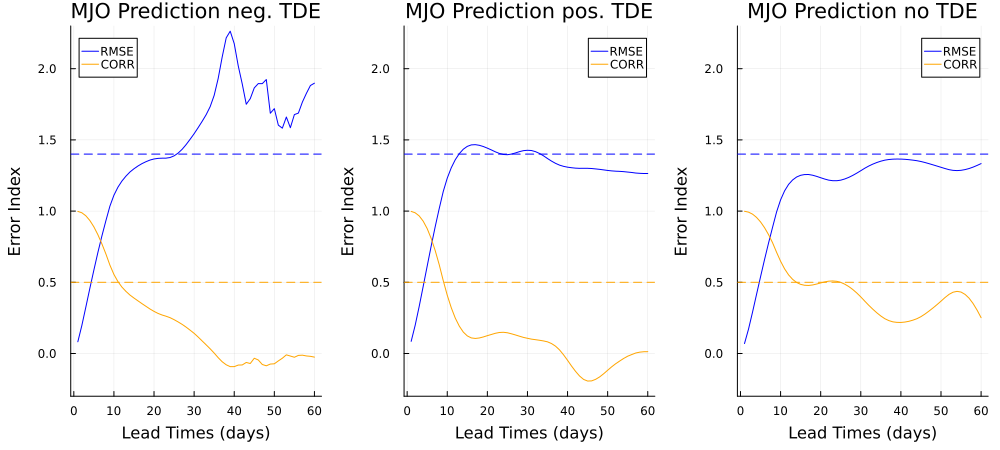

In [86]:
# compare error curves
plot(error_tde, error_pos_tde, error_no_tde, layout=(1,3), size=(1000,450), bottom_margin=5mm, left_margin=5mm)

In [87]:
using Plots.Measures

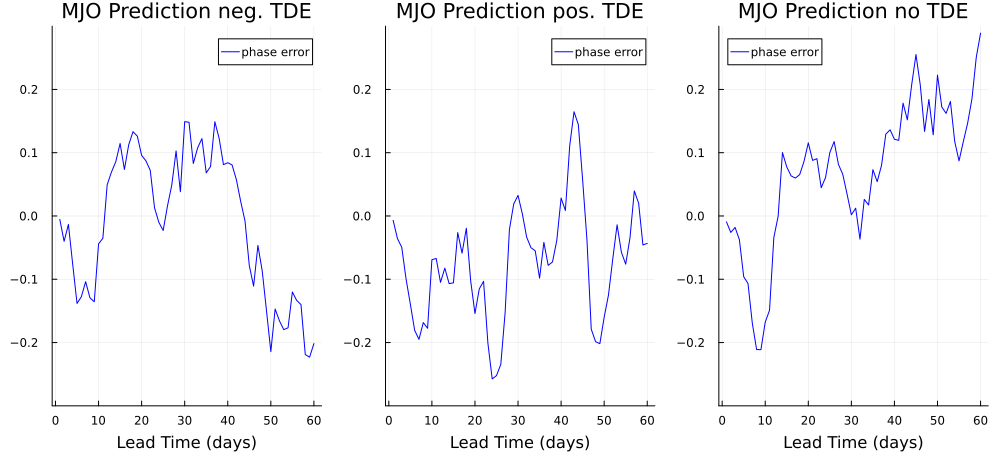

In [88]:
plot(phase_error_tde, phase_error_pos_tde, phase_error_no_tde,layout=(1,3), size=(1000,460), bottom_margin=5mm)

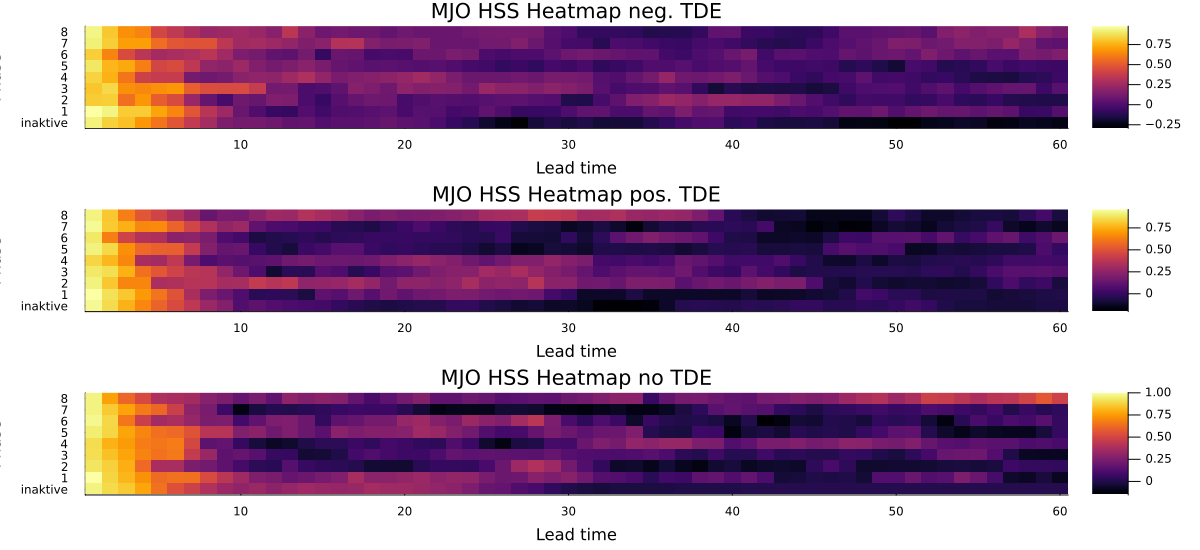

In [89]:
# compare hss heatmaps
plot(hss_tde, hss_pos_tde, hss_no_tde, layout=(3,1), size=(1200,550), bottom_margin=5mm)